## Recurrent Neural Networks

(in Keras TensorFlow)



In [91]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint

# choose a different matplotlib style (all styles can be found at https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html)
#print(plt.style.available)  # uncomment to see available styles
plt.style.use('dark_background')

### Duffing Oscillator Task

Prediction of the response under some given external harmonic forcing. 

In [92]:
def duffing(t, q, alpha=1.0, beta=1.0, delta=0.2, gamma=0.3, omega=1.2):
    """Duffing oscillator differential equation."""
    q1, q2 = q
    dq1dt = q2
    dq2dt = -delta * q2 - alpha * q1 - beta * q1**3 + gamma * np.cos(omega * t)
    return np.array([dq1dt, dq2dt])


# some function that integrates the diff. eq. for some given initial state
def integrate_duffing(t, q0, 
                      params={"alpha":1.0, "beta":1.0, "delta":0.2, "gamma":0.3, "omega":1.2}):
    """ Integrate using scipi's odeint"""
    
    alpha = params["alpha"]
    beta = params["beta"]
    delta = params["delta"]
    gamma = params["gamma"]
    omega = params["omega"] 


    return odeint(duffing, q0, t, args=(alpha,beta, delta, gamma, omega), tfirst=True)  

def create_dataset(n_samples=100, 
                   t = np.arange(0, 50, 0.1),
                   params={"alpha":1.0, "beta":1.0, "delta":0.2, "gamma":0.3, "omega":1.2}):
    """Create a dataset of the Duffing oscillator.
    
    Starts from the same initial condition (0,0) and integrates the system
    Varies the forcing amplitude between 0.1 and 0.5
    """

    # initial states drawn from a certain region of the state space
    q0 = np.array([0.0, 0.0])

    # loop through the initial conditions and integrate the system
    data = []
    for i in range(n_samples):
        
        # random variation of the forcing amplitude
        _gamma = np.random.uniform(0.25, 0.5)
        params["gamma"] = _gamma

        _q = integrate_duffing(t, q0, params)
        _f = np.expand_dims(params["gamma"] * np.cos(params["omega"] * t), axis=-1)  # forcing function
       
        data.append(np.column_stack((_q, _f)))

    return np.array(data)


## Generate data

In [93]:
# parameters for the Duffing oscillator
params = {"alpha":1.0, 
          "beta":1.0, 
          "delta":0.2, 
          "gamma":0.3, 
          "omega":1.2}

# create a dataset with a given number of samples
n_samples =100
t = np.arange(0, 50, 0.1)
data = create_dataset(n_samples, t=t, params=params)

print(f'shape of the dataset: {data.shape}')

shape of the dataset: (100, 500, 3)


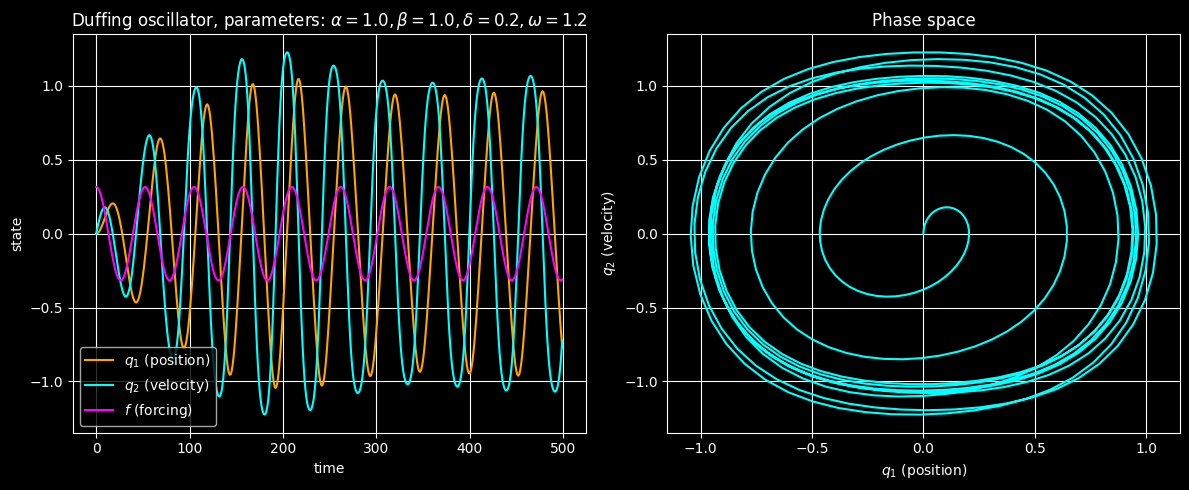

In [94]:
# investigate the dataset
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # time trace
plt.plot(data[0,:, 0], label=r'$q_1$ (position)', color='orange')
plt.plot( data[0,:, 1], label=r'$q_2$ (velocity)', color='cyan')
plt.plot(data[0,:, 2], label=r'$f$ (forcing)', color='magenta')
plt.title(rf'Duffing oscillator, parameters: '\
          rf'$\alpha={params["alpha"]}, \beta={params["beta"]}, \delta={params["delta"]}, \omega={params["omega"]}$')
plt.xlabel('time')
plt.ylabel('state')
plt.legend()
plt.grid()


plt.subplot(1, 2, 2)  # phase space
plt.plot(data[0,:, 0], data[0,:, 1], color='cyan')
plt.title('Phase space')
plt.xlabel(r'$q_1$ (position)')
plt.ylabel(r'$q_2$ (velocity)')
plt.grid()
plt.tight_layout()
plt.savefig('duffing_oscillator.png', dpi=300)
plt.show()


(100,)


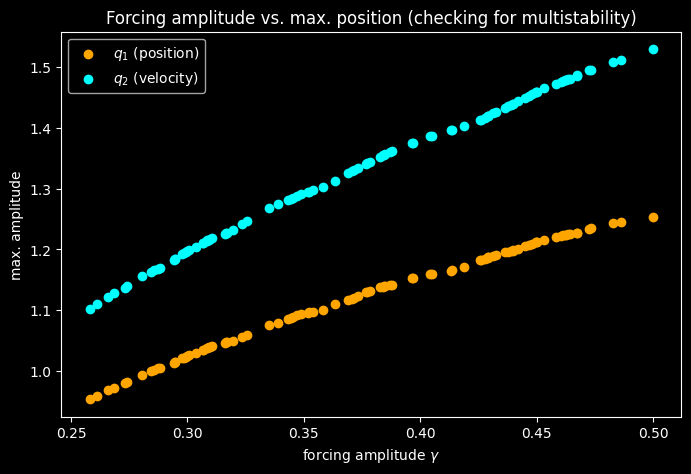

In [95]:
print(np.max(np.abs(data[:, :, 2]), axis=-1).shape)
# make sure that be variation of the forcing amplitude we do not create other dynamics
plt.figure(figsize=(8, 5))
plt.scatter(np.max(np.abs(data[:, :, 2]), axis=-1), np.max(np.abs(data[:, :, 0]), axis=-1), label=r'$q_1$ (position)', color='orange')
plt.scatter(np.max(np.abs(data[:, :, 2]), axis=-1), np.max(np.abs(data[:, :, 1]), axis=-1), label=r'$q_2$ (velocity)', color='cyan')
plt.legend()
plt.title('Forcing amplitude vs. max. position (checking for multistability)')
plt.xlabel(r'forcing amplitude $\gamma$')
plt.ylabel(r'max. amplitude')
plt.savefig('duffing_forcing_vs_position.png', dpi=300)
plt.show()

### First Modeling Task: Sequence to Sequence (seq2seq)

We will train a recurrent neural network that consumes the harmonic forcing signal as input, and predicts the system response as output:

`x`: $f(t)$

`y`: $[x(t), \dot{x}(t)]$

for a given time vector $t=[t_0, ... t_{500}]$. We call this a sequence translation task.

**Attention**: make sure to use the `return_sequences` flag appropriately! Whenever you do not do a direct sequence-to-sequence translation, your output layer should not return sequences!!! 

### Create a training and test set

We will train the model on the training set, and evaluate predictions on the test set to assess the generalization properties. The validation set is used to stop training. We split according to a 70-15-15 ratio. 

It is highly recommended to use sklearn's splitting functionalities, particularly the stratified splitting when working with classification problems. **However**: sklearn only supports 2D data. Here we have 3D data. Hence we need a short work-around via some index vector.

In [96]:
from sklearn.model_selection import train_test_split


# Split the dataset into training, validation and test sets
all_indices = list(range(data.shape[0])) # create a list of all indices
idx_train, idx_temp = train_test_split(all_indices, test_size=0.3, random_state=42)
idx_val, idx_test = train_test_split(idx_temp, test_size=0.5, random_state=42)

# Input: forcing function
x_train = np.expand_dims(data[idx_train, :, -1], axis=-1)  # forcing function
x_val = np.expand_dims(data[idx_val, :, -1], axis=-1)    
x_test = np.expand_dims(data[idx_test, :, -1], axis=-1)  

# Output: position and velocity
y_train = data[idx_train, :, :2]  
y_val = data[idx_val, :, :2]
y_test = data[idx_test, :, :2]

print(f'shape of training input: {x_train.shape}, shape of training output: {y_train.shape}')

print(f'number of training samples: {len(x_train)}')
print(f'number of validation samples: {len(x_val)}')
print(f'number of test samples: {len(x_test)}')


shape of training input: (70, 500, 1), shape of training output: (70, 500, 2)
number of training samples: 70
number of validation samples: 15
number of test samples: 15


### Building a Recurrent Neural Network in Keras



In [97]:
# import required tensorflow keras modules
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM

# Define the model architecture
def create_seq2seq_model(input_shape, output_shape, num_layers, num_hidden_units):
    """Create a sequence-to-sequence model with LSTM layers.
    
    shapes should be in the form of (timesteps, features).
    """
    
    model = Sequential()
    # Input layer
    model.add(Input(shape=input_shape))
    
    # Add LSTM layers
    for _ in range(num_layers-1):
        model.add(LSTM(num_hidden_units, activation='tanh', return_sequences=True))
        
    # Output layer
    model.add(LSTM(output_shape[-1], activation='linear', return_sequences=True))  # output position and velocity

    model.compile(optimizer='adam', loss='mse')  # compile the model with Adam optimizer and mean squared error loss
    model.summary()  # print the model summary

    return model

lstm_model = create_seq2seq_model(input_shape=x_train.shape[1:],
                                  output_shape=y_train.shape[1:],
                                  num_layers=3,
                                  num_hidden_units=64)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 500, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 500, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 500, 2)         │           536 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,456 (197.09 KB)

 Trainable params: 50,456 (197.09 KB)

 Non-trainable params: 0 (0.00 B)

### Train the recurrent seq2seq model



In [98]:
from tensorflow.keras.callbacks import EarlyStopping # for early stopping during training

# Define Early Stopping Callback. Stops training when the validation loss does not improve 
# for a given number of epochs.
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=20,  # for how many epochs to wait for improvement
                           verbose=2,
                           restore_best_weights=True, # reclaim the best weights after stopping, not the last weights
                           )

# Train the model on the training data. The returned `history` object contains training metrics.
history = lstm_model.fit(x_train, y_train, # training data
                    validation_data=(x_val, y_val), # validation data to monitor performance on unseen data
                    epochs=200, # how many times to iterate over the training data
                    batch_size=64,  # how many samples to process before updating the model weights 
                    verbose=2,  # verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch)
                    callbacks=[early_stop], # use early stopping
                    )  

# store the model to disk
lstm_model.save('seq2seq_rnn_model.keras')

Epoch 1/200
2/2 - 3s - 1s/step - loss: 0.5567 - val_loss: 0.5484
Epoch 2/200
2/2 - 1s - 317ms/step - loss: 0.5291 - val_loss: 0.5194
Epoch 3/200
2/2 - 1s - 288ms/step - loss: 0.5017 - val_loss: 0.4858
Epoch 4/200
2/2 - 1s - 290ms/step - loss: 0.4696 - val_loss: 0.4451
Epoch 5/200
2/2 - 1s - 339ms/step - loss: 0.4304 - val_loss: 0.3973
Epoch 6/200
2/2 - 1s - 524ms/step - loss: 0.3838 - val_loss: 0.3472
Epoch 7/200
2/2 - 2s - 757ms/step - loss: 0.3328 - val_loss: 0.2997
Epoch 8/200
2/2 - 3s - 1s/step - loss: 0.2832 - val_loss: 0.2581
Epoch 9/200
2/2 - 1s - 659ms/step - loss: 0.2447 - val_loss: 0.2300
Epoch 10/200
2/2 - 1s - 610ms/step - loss: 0.2198 - val_loss: 0.1788
Epoch 11/200
2/2 - 1s - 649ms/step - loss: 0.1721 - val_loss: 0.1365
Epoch 12/200
2/2 - 1s - 585ms/step - loss: 0.1321 - val_loss: 0.1619
Epoch 13/200
2/2 - 1s - 698ms/step - loss: 0.1527 - val_loss: 0.1407
Epoch 14/200
2/2 - 1s - 564ms/step - loss: 0.1334 - val_loss: 0.1207
Epoch 15/200
2/2 - 1s - 620ms/step - loss: 0.1177

#### Visualize the NN training run

We have trained the NN to reduce the MSE error on the training set. During each optimization iteration, we have also used the current model weights to make predictions on the hold-out test set. Hence, we can study how well the model generalizes to new unseen data points, and identify the point at which overfitting sets in (loss for training set decreases, loss for test set increases).

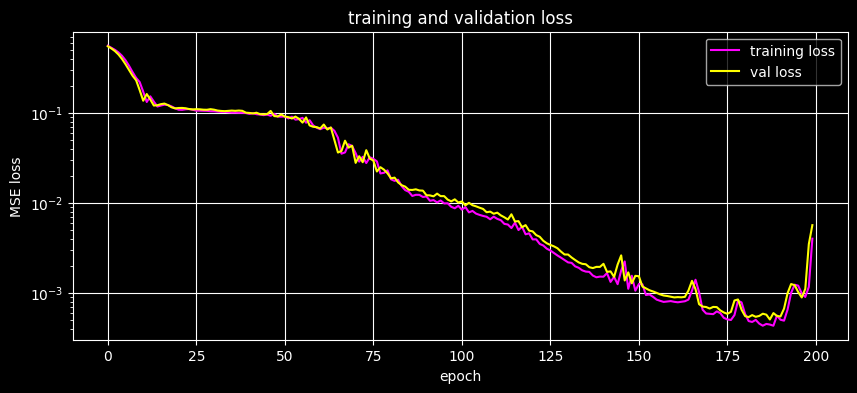

In [99]:

# Plot the training and test loss over epochs
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='training loss', color='magenta')
plt.plot(history.history['val_loss'], label='val loss', color='yellow')

plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.yscale('log')  # use logarithmic scale for better visibility of loss values
plt.title('training and validation loss')
plt.grid()
plt.show()

### Evaluate the model

Let's see how well the model can make predictions on data that was not used for training, i.e. on the test set samples. 

To make predictions, call `model.predict(x)`, where is are new inputs.

For regression tasks the $R^2$ score is the most-used metric, ranging from $0.0$ (not better than predicting the average target value) to $1.0$ (perfect mdoel).

We will use a plot that shows the predicted against the expected (i.e. ground truth targets) values. A perfect model would result in the identity line. 

In [100]:
# load the model from disk (if needed)
from tensorflow.keras.models import load_model
model = load_model('seq2seq_rnn_model.keras')

# plot the predictions vs. ground truth
y_pred = model.predict(x_test)

# evaluate the R2 score <-- best way to evaluate regression models
from sklearn.metrics import r2_score

# we need to flatten the 3d arrays to 2d arrays for the r2_score function
y_test_flat = y_test.reshape(y_test.shape[0]*y_test.shape[1], y_test.shape[2])
y_pred_flat = y_pred.reshape(y_pred.shape[0]*y_pred.shape[1], y_pred.shape[2])

# calculate the R2 score
r2 = r2_score(y_test_flat, y_pred_flat)
print(f'R2 score: {r2:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
R2 score: 0.9991


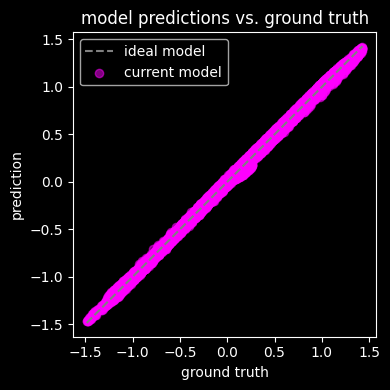

In [101]:

plt.figure(figsize=(4, 4))
plt.plot([y_test_flat.min(), y_test_flat.max()], [y_test_flat.min(), y_test_flat.max()], color='gray', linestyle='--', label='ideal model')
plt.xlabel(r'ground truth')
plt.ylabel(r'prediction')
plt.scatter(y_test_flat.flatten(), y_pred_flat.flatten(), alpha=0.5, color='magenta', label='current model')
plt.title('model predictions vs. ground truth')
plt.legend()
plt.tight_layout()
plt.show()



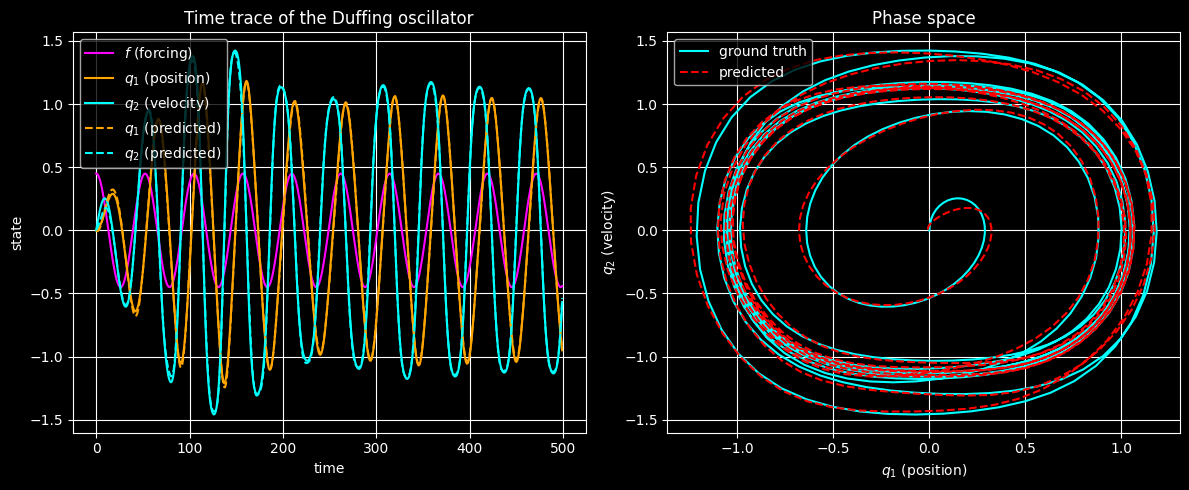

In [102]:
# let it make predictions on the test set

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # time trace
plt.plot(x_test[0, :, 0], label=r'$f$ (forcing)', color='magenta')
plt.plot(y_test[0, :, 0], label=r'$q_1$ (position)', color='orange')
plt.plot(y_test[0, :, 1], label=r'$q_2$ (velocity)', color='cyan')
plt.plot(y_pred[0, :, 0], label=r'$q_1$ (predicted)', color='orange', linestyle='--')
plt.plot(y_pred[0, :, 1], label=r'$q_2$ (predicted)', color='cyan', linestyle='--')
plt.legend()
plt.title('Time trace of the Duffing oscillator')
plt.xlabel('time')
plt.ylabel('state')
plt.grid()
plt.subplot(1, 2, 2)  # phase space
plt.plot(y_test[0, :, 0], y_test[0, :, 1], color='cyan', label='ground truth')
plt.plot(y_pred[0, :, 0], y_pred[0, :, 1    ], color='red', linestyle='--', label='predicted')
plt.title('Phase space')
plt.xlabel(r'$q_1$ (position)')
plt.ylabel(r'$q_2$ (velocity)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('duffing_predictions.png', dpi=300)
plt.show()

### Deploy model for predictions

We will use the model to compute the system response for a different forcing signal. Training range was 0.25-0.5 in forcing amplitude $\gamma$.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


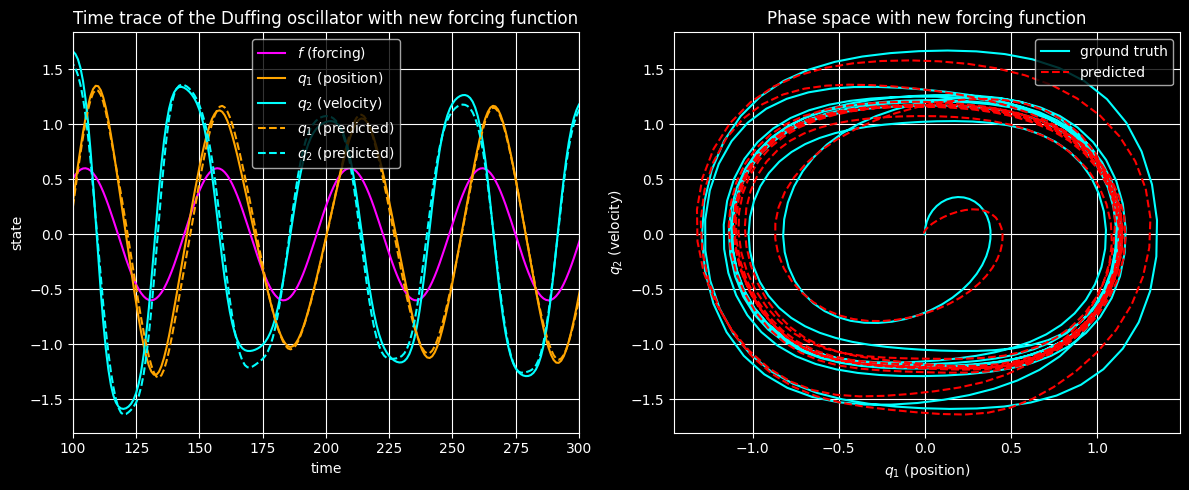

In [109]:
params_new = params.copy()  # create a copy of the original parameters
params_new["gamma"] = 0.6  # update the forcing amplitude
# params_new["omega"] = 1.5  # update the forcing frequency

f_new = params_new["gamma"] * np.cos(params_new["omega"] * t)

# compute ground truth for the new forcing function
q_new = integrate_duffing(t, np.array([0.0, 0.0]), params_new)

# make predictions for the new forcing function
x_new = np.expand_dims(f_new, axis=-1)  # reshape to match the input shape of the model
y_pred_new = model.predict(np.expand_dims(x_new, axis=0))  # add batch dimension

# plot the predictions vs. ground truth for the new forcing function
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # time trace
plt.plot(f_new, label=r'$f$ (forcing)', color='magenta')
plt.plot(q_new[:, 0], label=r'$q_1$ (position)', color='orange')
plt.plot(q_new[:, 1], label=r'$q_2$ (velocity)', color='cyan')
plt.plot(y_pred_new[0, :, 0], label=r'$q_1$ (predicted)', color='orange', linestyle='--')
plt.plot(y_pred_new[0, :, 1], label=r'$q_2$ (predicted)', color='cyan', linestyle='--')
plt.legend()
plt.title('Time trace of the Duffing oscillator with new forcing function')
plt.xlabel('time')
plt.ylabel('state')
plt.grid()
plt.xlim([100, 300])

plt.subplot(1, 2, 2)  # phase space
plt.plot(q_new[:, 0], q_new[:, 1], color='cyan', label='ground truth')
plt.plot(y_pred_new[0, :, 0], y_pred_new[0, :, 1], color='red', linestyle='--', label='predicted')
plt.title('Phase space with new forcing function')
plt.xlabel(r'$q_1$ (position)')
plt.ylabel(r'$q_2$ (velocity)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('duffing_predictions_new_forcing.png', dpi=300)
plt.show()
